# Tarea 2: Deep Learning 

- Martínez Ostoa Néstor I. 
- Lic. en Ciencia de Datos - IIMAS - UNAM

--- 

**Descripción**: mejora los resultados de la red neuronal densa para un conjunto de tweets

## Carga de datos

In [1]:
import os

URL = 'https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv'
data_folder = 'data'
filepath = os.path.join(data_folder, 'text_emotion.csv')

# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘data’: File exists
File ‘data/text_emotion.csv’ already there; not retrieving.


## Análisis del conjunto de datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/text_emotion.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger

40,000 tweets


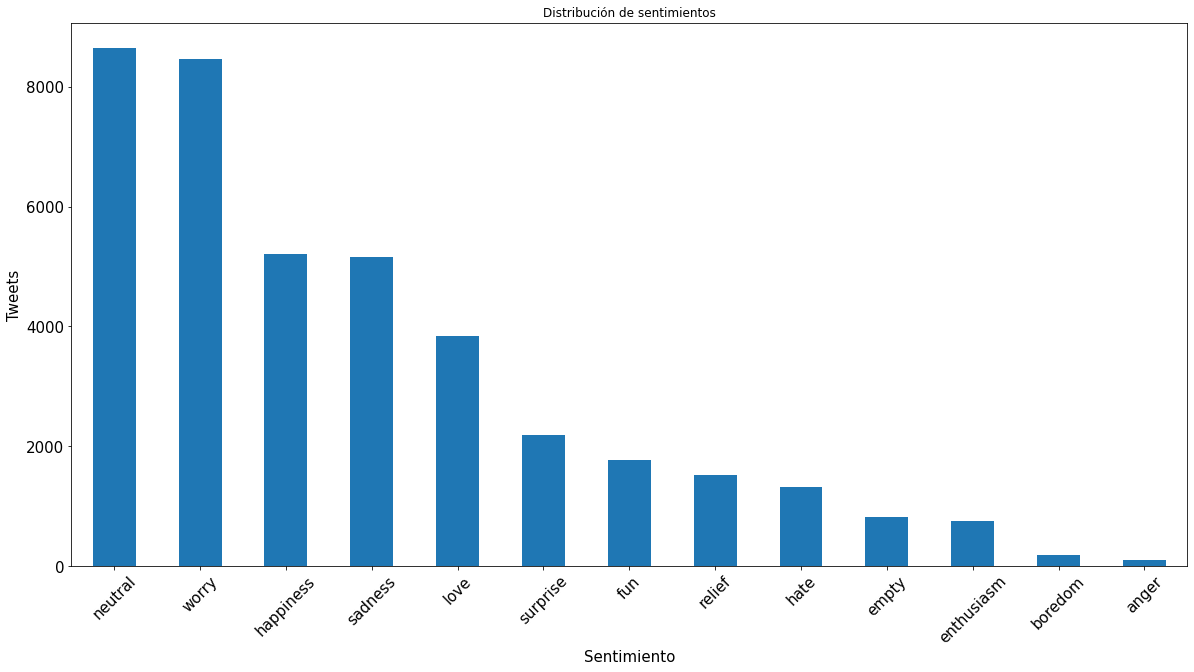

In [4]:
sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(20, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

## Preprocesamiento de los datos

1. Tokenización de cada tweet
2. Estandarizar las palabras en minúsculas
3. Quitar stopwords y signos de puntuación
4. Stematización

In [5]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [6]:
df.drop('tweet_id', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

In [7]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    str_ = ""
    for t in tweets_clean: str_ += t + ' '
    return str_

# Reference: Coursera NLP Specialization 

In [8]:
df['content'] = df['content'].apply(lambda x: process_tweet(x))

In [9]:
print(df.shape)
df.head()

(40000, 2)


,sentiment,content
0,empty,know listenin bad habit earlier start freakin ...
1,sadness,layin n bed headach ughhh ... waitin call ...
2,sadness,funer ceremoni ... gloomi friday ...
3,enthusiasm,want hang friend soon
4,neutral,want trade someon houston ticket one


## Preparar el conjunto de datos

In [10]:
# obtener diccionario de clases (Y)
sentiments = df['sentiment'].to_dict()

labels = list(set(sentiments.values()))
labels.sort()
print(f"Labels: {labels}")

label2idx = {label:i for i, label in enumerate(labels)}
idx2label = {label2idx[lbl] : lbl for lbl in label2idx}

print (f"\nlabel2idx=\n{label2idx}")
print (f"\nidx2label=\n{idx2label}")

print (f"\n\nNúmero de etiquetas (clases): {len(label2idx):,}")

Labels: ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']

label2idx=
{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}

idx2label=
{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}


Número de etiquetas (clases): 13


In [11]:
# obtener diccionario de tweets (X)
tweets = df['content'].to_list()

tokens = set({token.lower() for tweet in tweets for token in tweet.split()})
tokens2idx = {'<<padding>>': 0} # <pad>, <PAD>, pad
tokens2idx.update({token : i+1 for i, token in enumerate(tokens)})
print (tokens2idx)
print (f"Longitud del vocabulario: {len(tokens2idx):,}")

max_tweet_length = 0
min_tweet_length = 100

X, Y = [], []

for index, row in df.iterrows():

  # reemplazar la etiqueta (sentiment) por su id en el conjunto de datos
  label = row['sentiment']
  # df.at[index, 'sentiment'] = label2idx[label]
  Y.append(label2idx[label])

  # obtener la longitud máxima y mínima del tweet
  if len(row['content'].split()) > max_tweet_length: max_tweet_length = len(row['content'].split())
  if len(row['content'].split()) < min_tweet_length: min_tweet_length = len(row['content'].split())
  
print (f"Tweet con la longitud máxima: {max_tweet_length:,}")
print (f"Tweet con la longitud mínima: {min_tweet_length:,}")

for index, row in df.iterrows():

  # reemplazar token en el tweet
  idx2token = [tokens2idx[token] for token in row['content'].lower().split()]

  # verificar si el tweet actual cuenta con la longitud máxima
  if len(idx2token) < max_tweet_length:
    n_padding = max_tweet_length - len(idx2token)
    idx2token += [tokens2idx['<<padding>>']] * n_padding # rellenar tweet

  # reemplazar el tweet (oración) con su lista de ids en el conjunto de datos
  # df.at[index, 'content'] = idx2token
  X.append(idx2token)

print (f"Longitud X: {len(X)}")
print (f"Longitud Y: {len(Y)}")

print ("=========================>",X[0])


{'<<padding>>': 0, 'wiki': 1, 'arrang': 2, 'ltj': 3, 'sticker': 4, 'similarli': 5, 'nanay': 6, 'monica': 7, 'houston': 8, 'depend': 9, 'chichest': 10, 'todat': 11, 'pog': 12, 'whyd': 13, 'uduhn': 14, 'drive-in': 15, 'biscuit': 16, 'aot': 17, 'jen': 18, 'holli': 19, 'fyi': 20, 'creditcard-s': 21, 'rollercoast': 22, 'tortilla': 23, "jhy'": 24, 'woohoo': 25, 'sci': 26, 'heltershelt': 27, 'be4': 28, 'westconn': 29, 'loggad': 30, 'heheheh': 31, 'whn': 32, 'eve': 33, 'pretzel': 34, 'tonyt': 35, 'onigiri': 36, 'notin': 37, 'act': 38, 'scorecard': 39, 'pebbl': 40, 'financ': 41, 'hulu.com': 42, 'dmp': 43, 'peni': 44, 'impos': 45, 'carseat': 46, 'probbi': 47, "amanda'": 48, 'deep': 49, 'congest': 50, 'mhmm': 51, 'along': 52, 'd-fail': 53, 'heal': 54, 'loudli': 55, 'b': 56, 'whhaacck': 57, 'boast': 58, 'defer': 59, 'balloon': 60, 'pina': 61, 'beans.but': 62, 'ado': 63, 'elisa': 64, 'wallac': 65, 'airplan': 66, "cic'": 67, 'alejandra': 68, 'kelli': 69, 'muster': 70, 'boomin': 71, 'tja': 72, "resum

Tweet con la longitud máxima: 49
Tweet con la longitud mínima: 0
Longitud X: 40000
Longitud Y: 40000
=========================> [15136, 17116, 6693, 11706, 920, 8865, 7170, 22222, 21760, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Dividir en train y test

In [12]:
# preparar el conjunto de datos
Y = np.array(Y, dtype="float32")[:, np.newaxis]

print (f"Shape Y:\t{Y.shape}")
print (Y)

X = np.array(X, dtype="float32")
print (f"\nShape X:\t{X.shape}")
print (X)

Shape Y:	(40000, 1)
[[ 2.]
 [10.]
 [10.]
 ...
 [ 7.]
 [ 5.]
 [ 7.]]

Shape X:	(40000, 49)
[[15136. 17116.  6693. ...     0.     0.     0.]
 [19405.  8202.  3473. ...     0.     0.     0.]
 [11781. 18168. 22629. ...     0.     0.     0.]
 ...
 [10883. 19015.  3860. ...     0.     0.     0.]
 [25199.  4538. 20545. ...     0.     0.     0.]
 [19531. 21979.  4784. ...     0.     0.     0.]]


In [13]:
# dividir el conjunto de entrenamiento en Train and Test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=0)

print(f"X_train.shape, Y_train.shape: {X_train.shape}, {Y_train.shape}")
print(f"X_test.shape, Y_test.shape: {X_test.shape}, {Y_test.shape}")

X_train.shape, Y_train.shape: (28000, 49), (28000, 1)
X_test.shape, Y_test.shape: (12000, 49), (12000, 1)


## TensorDataset y DataLoader

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# crear los tensores del conjunto de datos
train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

print (train[0])

# crear los cargadores del conjunto de datos
trainloader = DataLoader(train, batch_size=100, shuffle=True)
testloader = DataLoader(test, batch_size=100, shuffle=True)


(tensor([12668., 10883.,  3819., 15136., 15213.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]), tensor([7.]))


## PyTorch

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Modelo Lineal

In [16]:
import math

class NNAnalisisSentimientos(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, labels_dim):
    super(NNAnalisisSentimientos, self).__init__()

    # input_dim = máxima longitud de tweets  
    self.fc1 = nn.Linear(input_dim, hidden_dim)

    # definir una función no líneal de activación 1
    self.activation1 = nn.Sigmoid()

    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    # definir una función no líneal de activación 2
    self.activation2 = nn.Sigmoid()

    # Linear function 3 (readout): 500 --> 3
    self.fc3 = nn.Linear(hidden_dim, labels_dim)

  def forward(self, x):
    # propagación hacia adelante

    out = self.fc1(x)

    # Non-linearity 1
    out = self.activation1(out)

    # Linear function 2
    out = self.fc2(out)

    # Non-linearity 2
    out = self.activation2(out)

    # Linear function 3 (readout)
    out = self.fc3(out)

    out = F.log_softmax(out, dim=1)

    return out

## Entrenamiento

In [17]:
# Instanciar el modelo
input_dim = max_tweet_length
hidden_dim = 500
labels_dim = len(label2idx)

model = NNAnalisisSentimientos(input_dim, hidden_dim, labels_dim)

model

NNAnalisisSentimientos(
  (fc1): Linear(in_features=49, out_features=500, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (activation2): Sigmoid()
  (fc3): Linear(in_features=500, out_features=13, bias=True)
)

In [ ]:
EPOCHS = 20
loss_plot, acc_plot = [], []


# definir la función de pérdida: Entropía Cruzada
loss_function = nn.CrossEntropyLoss()

# defnir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.01)

# realizar el entrenamiento
for epoch in range(EPOCHS):
    total_loss, correct, total = 0, 0, 0
    for x, y in trainloader: 
        # establecer los gradientes a cero
        optimizer.zero_grad()

        # forward + loss + backward + optimise (update weights)
        # propagación hacia adelante
        y_hat = model(x)

        # convertir nuestro 
        target = torch.tensor(y.squeeze(1), dtype=torch.long).clone().detach()

        loss = loss_function(y_hat, target)
        
        # retropropagación
        loss.backward()

        optimizer.step()

        # registrar la pérdida o error (loss)
        total_loss += loss.item()
        
        y_hat = F.softmax(y_hat, dim=1)
        count = [1 for i, j in zip(torch.argmax(y_hat, dim=1), y) if i == j]
        correct += sum(count)
        total += len(y)
        acc = ((100.0 * correct) / total)

    
    total_loss /= len(y)

    print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {total_loss:4.2f}, Accuracy: {acc:2.2f}%")
    loss_plot.append(total_loss)
    acc_plot.append(acc)

<ipython-input-18-4cfe9d65d997>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y.squeeze(1), dtype=torch.long).clone().detach()


Epoch: 1/20, Loss: 6.05, Accuracy: 22.01%
Epoch: 2/20, Loss: 6.00, Accuracy: 23.41%
Epoch: 3/20, Loss: 5.99, Accuracy: 23.88%
Epoch: 4/20, Loss: 5.98, Accuracy: 24.55%
Epoch: 5/20, Loss: 5.98, Accuracy: 24.56%
Epoch: 6/20, Loss: 5.98, Accuracy: 24.64%
Epoch: 7/20, Loss: 5.97, Accuracy: 24.82%
Epoch: 8/20, Loss: 5.97, Accuracy: 24.91%
Epoch: 9/20, Loss: 5.97, Accuracy: 25.05%
Epoch: 10/20, Loss: 5.97, Accuracy: 24.86%
Epoch: 11/20, Loss: 5.97, Accuracy: 25.07%
Epoch: 12/20, Loss: 5.97, Accuracy: 25.09%
Epoch: 13/20, Loss: 5.97, Accuracy: 25.10%
Epoch: 14/20, Loss: 5.96, Accuracy: 25.04%
Epoch: 15/20, Loss: 5.96, Accuracy: 25.04%
Epoch: 16/20, Loss: 5.96, Accuracy: 25.14%
Epoch: 17/20, Loss: 5.96, Accuracy: 25.17%
Epoch: 18/20, Loss: 5.96, Accuracy: 25.15%
Epoch: 19/20, Loss: 5.96, Accuracy: 25.19%


## Evaluar el modelo

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Visualizar la pérdida
plt.plot(loss_plot, 'tab:orange', label='train loss')
plt.legend(loc='best')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

# Visualizar la exactitud
plt.plot(acc_plot, 'tab:green', label='train acc')
plt.legend(loc='best')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

with torch.no_grad():
  model.eval()

  y_true, y_pred = [], []
  correct, total = 0, 0

  for x, y in testloader:
    y_hat = model(x)
    
    y = torch.tensor(y.squeeze(1), dtype=torch.long)
    y_hat = torch.argmax(y_hat, dim=1)

    y_true += list(y.cpu().numpy())
    y_pred += list(y_hat.cpu().numpy())
    
    count = [1 for i, j in zip(y_hat, y) if i == j]
    correct += sum(count)
    total += len(y)

print(f'Exactitud del Test: {(100.0 * correct) / total:2.2f}%')
print(f'Exactitud del Test: {accuracy_score(y_true, y_pred):2.2f}%')

print (label2idx)
print( classification_report(y_true, y_pred, target_names=list(label2idx.keys()) ) )